##### Hidrologia e Recursos Hídricos
## Auxiliar para o trabalho 5
### Introdução
Isto é um "jupyter workbook" (https://jupyter.org/). Basicamente, trata-se de uma ferramenta online em que se pode correr e modificar código Python em tempo real e em paralelo.
Python é um linguagem fácil de aprender e muito útil, podendo servir para scripts simples ou produção e operacionalização de programas complexos (https://blog.boardinfinity.com/top-10-programming-languages-of-the-future/).
Certamente, dominar Python pode ajudá-los a singrar na vossa vida profissional, seja ela técnica ou académica.

Neste "workbook", dividido em vários passos, podem calcular-se os elementos principais da 6a parte do trabalho de Hidrologia e Recursos Hídricos. Espero que vos seja útil.

Shift-Enter serve para avançar em cada célula / correr o respectivo código. Podem editar as células com os parâmteros do vosso trabalho.
Cada bloco de código está acompanhado de uma pequena explicação e, ocasionalmente, comentários.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapefile as shp 
from matplotlib.patches import StepPatch

cm = 1/2.54  # conversão de cm para polegadas (útil para controlar o tamanho das figuras)

### Introduzir os dados de base
Abaixo podem substituir os dados por defeito com os da vossa bacia hidrográfica.

Comentários são marcados com "\#"

In [15]:
# Caracterização geomorfológica
area = 68.051078 # [km2]
comprimento = 14.21018787 # Comprimento do curso de água principal [km]
altura_media = 500 # Altura média da bacia hidrográfica [m]
diferenca_cotas = 521.86 # Diferença de cotas entre o ponto mais alto e o mais baixo do curso de água principal [m]
declive_medio = 0.036724 # Declive médio adimensional [-] ou [m/m]
declive_10_85 = 29.723 # Declive 10:85 [m/km]

# Caracterização da precipitação
    # Número de blocos utilizados no hietograma
numero_blocos = 10

    # Coeficientes da linha de possibilidade udométrica P=a*t^n para P em [mm] e t em [hr].
n = 0.3282
a_hr = 29.999
    # Cálculo do a para t em [min]
a = a_hr/60**n

    # Fracção de perdas (e.g., devidas à infiltração, detenção, intercepção, evaporação, etc.)
perdas = 0.25

# Caracterização da duração "D" como fracção do tempo de concentração.
d = 1/10 # 

# Caracterização do HUD a partir de uma lista de coordenadas (x, y) em unidades de "D".
hud = [(0,0),
      (4,1),
      (11,0),
      ]

### Calcular o tempo de concentração
Segundo as fórmulas de:
-  Giandotti: $t_c=\frac{4\sqrt{A}+1.5L}{0.8\sqrt{hm}}$
-  Temez: $t_c=0.3\Big(\frac{L}{dm^{0.25}}\Big)^{0.75}$
-  NERC: $t_c=2.8\Big(\frac{L}{\sqrt{d_{10:85}}}\Big)^{0.47}$
-  Kirpich: $t_c=0.95\frac{L^{1.155}}{H^{0.385}}$

As unidades de cada variável estão indicadas no acima (introduzir os dados de base).
Todas as fórmulas devolvem a estimativa do tempo de concentração em horas.

O valor a utilizar corresponde à média das estimativas anteriores.

In [16]:
# Cálculo de cada formula para tc
tcs = {} # criação de um "dict" onde as várias estimativas são guardadas
tcs['Giandotti'] = (4*area**0.5+1.5*comprimento)/(0.8*altura_media**0.5)
tcs['Temez'] = 0.3*(comprimento/(declive_medio**0.25))**0.76
tcs['NERC'] = 2.8*(comprimento/(declive_10_85)**0.5)**0.47
tcs['Kirpich'] = 0.95*(comprimento**1.155/diferenca_cotas**0.385)

tcs = pd.DataFrame(data=tcs, index=['tc [hr]']).transpose() # armazenar os dados numa tabela
tc = tcs.mean().values[0] # .values[0] é um comando interno para retirar um valor "simples" da tabela

print('O valor de tc estimado é de %0.2f horas.' % tc) # %0.2f indica que se vai introduzir o valor depois to % (neste caso tc) como um "float" de duas casas decimais.
tcs

O valor de tc estimado é de 3.37 horas.


,tc [hr]
Giandotti,3.036162
Temez,4.224318
NERC,4.392413
Kirpich,1.831125


### Preparar o hidrograma unitário
As coordenadas do HUD introduzidas acima vão ser utilizadas para o construir. O ideal é fazer um hidrograma cujo volume integrado seja correspondente à precipitação de 1 mm com a duração "D".

Para uma precipitação efectiva de 1 mm, o volume precipitado é 68.05 dam3.
Com o umax original de 1.00 m3/s/mm, o volume escoado é 6.67 dam3.
O HUD de base é:


,tempo [hr],u [m3/s],rank
D,,,
0,0.000000,0.000000,11
1,0.337100,2.548886,9
2,0.674201,5.097773,6
3,1.011301,7.646659,3
4,1.348402,10.195546,1
5,1.685502,8.739039,2
6,2.022603,7.282533,4
7,2.359703,5.826026,5
8,2.696804,4.369520,7


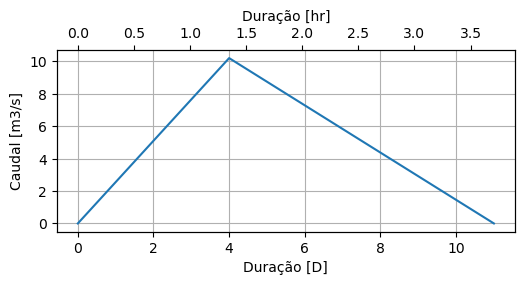

In [17]:
# Preparação do hidrograma unitário
d_hr = tc*d

x_hud = np.arange(hud[0][0], hud[-1][0]+1)*d_hr
u_hud = np.interp(x_hud, [x[0]*d_hr for x in hud], [y[1] for y in hud])
#u_hud /= max(u_hud)

vol_pe_1mm = area*1000000*0.001 # em m3
vol_hud = sum(u_hud[1:]+u_hud[0:-1])/2*d_hr*3600 # em m3. Calculado para trapézios (as coordenadas do HUD não precisam de fazer um triângulo).

hud_1mm = pd.DataFrame({'tempo [hr]': x_hud,
             'u [m3/s]': u_hud*vol_pe_1mm/vol_hud,
             })
hud_1mm.index.name = 'D'
hud_1mm.loc[:, 'rank'] = hud_1mm.loc[:, 'u [m3/s]'].rank(ascending=False).astype(int)

fig = plt.figure(figsize=(15*cm, 6*cm))
gs = fig.add_gridspec(nrows=1, ncols=2)

    # Hietograma
ax0 = fig.add_subplot(gs[:, :])
ax0.plot(hud_1mm.index, hud_1mm.loc[:, 'u [m3/s]'])
ax0.set_xlabel('Duração [D]')
ax0.set_ylabel('Caudal [m3/s]')
plt.grid()
ax1 = ax0.twiny()
ax1.set_xlim(ax0.get_xlim()[0]*d_hr, ax0.get_xlim()[1]*d_hr)
ax1.set_xlabel('Duração [hr]')

print('Para uma precipitação efectiva de 1 mm, o volume precipitado é %0.2f dam3.' % (vol_pe_1mm/1000))
print('Com o umax original de %0.2f m3/s/mm, o volume escoado é %0.2f dam3.' % (max(u_hud), vol_hud/1000))
print('O HUD de base é:')
hud_1mm



### Ilustrar a linha de possibilidade udométrica
Tendo calculado o tc, é possível estimar a precipitação de projecto para um dado período de retorno (no nosso caso 100 anos).
Para o fazer, é necessário utilizar a linha de possibilidade udométrica.

Para um período de retorno de 100 anos e um tc de 3.37 horas, a precipitação de projecto é 44.70 mm.


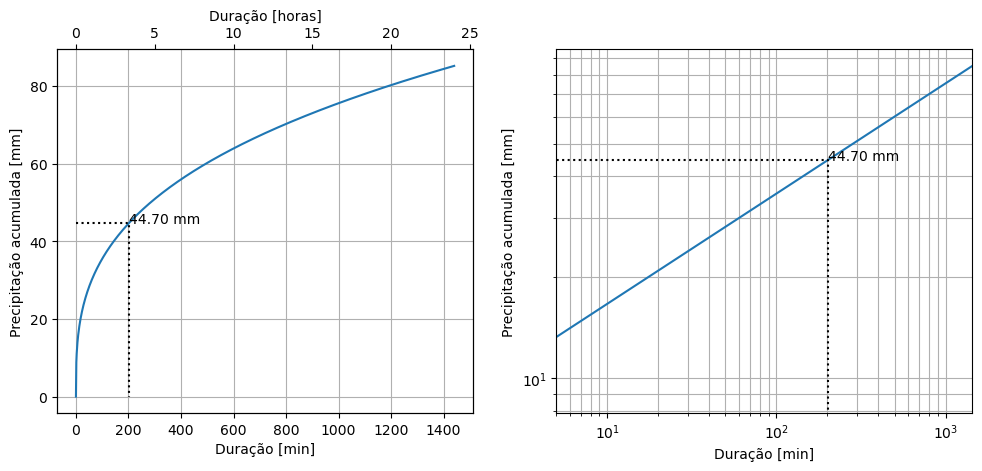

In [18]:
# Cálculo da precipitação de projecto e ilustração da linha de possibilidade udométrica

p_projecto = a*(tc*60)**n # multiplica-se por 60 para converter horas (unidades de tc) em minutos (unidades desta linha de possibilidade udométrica).
print('Para um período de retorno de 100 anos e um tc de %0.2f horas, a precipitação de projecto é %0.2f mm.' % (tc, p_projecto))

# Gráficos
    # Escala original
x = np.linspace(0, 24*60, 1000) # cria os valores x do gráfico. 1000 pontos entre 0 a 1 dias, em minutos.
p = a*x**n # aplicação da mesma fórmula a todos os x ao mesmo tempo.

fig = plt.figure(figsize=(30*cm, 12*cm))
gs = fig.add_gridspec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[:, 1])

_ = ax0.plot(x, p)
ax0.set_xlabel('Duração [min]')
ax0.set_ylabel('Precipitação acumulada [mm]')

        # Anotações e estilo
ax0.plot([0, tc*60, tc*60],[p_projecto, p_projecto, 0], ':k')
ax0.annotate('%0.2f mm' % p_projecto, (tc*60, p_projecto))
ax0.grid()
        
        # Segundo eixo horizontal
ax2 = ax0.twiny()
ax2.set_xlim(ax0.get_xlim()[0]/60, ax0.get_xlim()[1]/60)
ax2.set_xlabel('Duração [horas]')

    # Escala logarítmica
_ = ax1.loglog(x, p)
ax1.set_xlabel('Duração [min]')
ax1.set_ylabel('Precipitação acumulada [mm]')

        # Anotações e estilo
ax1.plot([0, tc*60, tc*60],[p_projecto, p_projecto, 0], ':k')
ax1.annotate('%0.2f mm' % p_projecto, (tc*60, p_projecto))
ax1.grid(True, which="both")
_ = ax1.set_xlim(5, 24*60)

### Preparar hietogramas
Os hietogramas uniforme e de blocos alternados são preparados com o código seguinte.

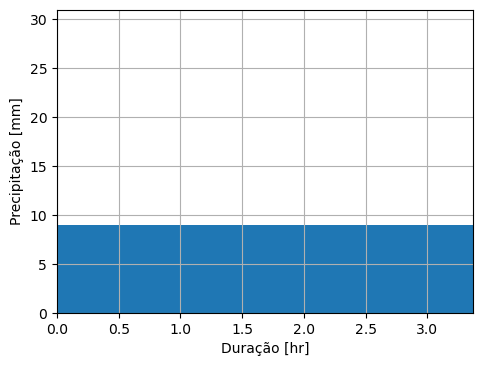

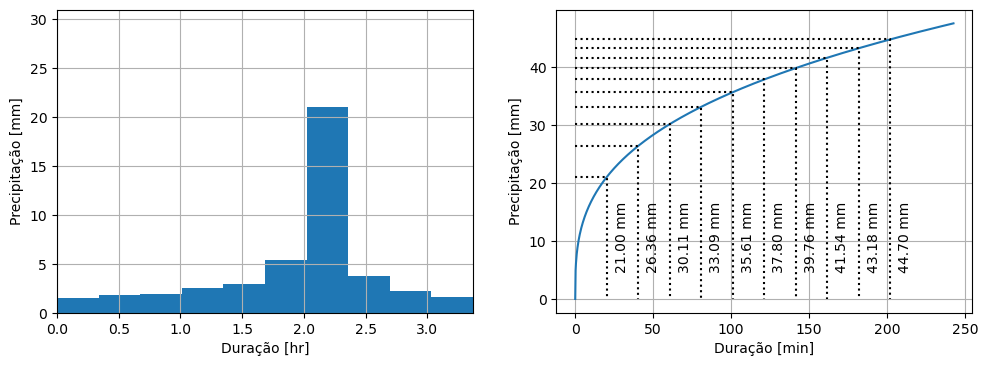

In [19]:
# Preparação do hietogramas de projecto

# Hietograma uniforme
intensidade = p_projecto/tc/60 # intensidade da precipitação [mm/min]
duracao = tc/numero_blocos*60 # minutos

fig = plt.figure(figsize=(30*cm, 10*cm))
ax0 = fig.add_subplot(gs[:, 0])
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=[intensidade*tc/5*60]*numero_blocos)
ax0.add_patch(patch)
ax0.set_xlim(0, tc)
ax0.set_ylim(0, a*(tc/numero_blocos*60)**n+10)

ax0.set_xlabel('Duração [hr]')
ax0.set_ylabel('Precipitação [mm]')
ax0.grid()

# Hietograma alternado
x = np.linspace(0, 6*tc/5*60, 1000) # cria os valores x do gráfico. 10000 pontos entre 0 a 1 dias, em minutos.
p = a*(x)**n # aplicação da mesma fórmula a todos os x ao mesmo tempo.

    # Obtenção dos valores para cada passo do hietograma
x_alternado = np.linspace(0, tc, numero_blocos+1)
p_alternado = a*(x_alternado*60)**n

p_diferencas = np.diff(p_alternado)
i_h_alternado = hud_1mm.loc[:, 'rank'].iloc[1:-1][::-1]-1
p_h_alternado = p_diferencas[i_h_alternado]


fig = plt.figure(figsize=(30*cm, 10*cm))
    # Hietograma
ax0 = fig.add_subplot(gs[:, 0])
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=p_h_alternado)
ax0.add_patch(patch)
ax0.set_xlim(0, tc)
ax0.set_ylim(0, a*(tc/numero_blocos*60)**n+10)

ax0.set_xlabel('Duração [hr]')
ax0.set_ylabel('Precipitação [mm]')
plt.grid()

    # Linha de possibilidade hidrométrica anotada
gs = fig.add_gridspec(nrows=1, ncols=2)
ax1 = fig.add_subplot(gs[:, 1])
_ = ax1.plot(x, p)
ax1.set_xlabel('Duração [min]')
ax1.set_ylabel('Precipitação [mm]')
for i0 in range(0, numero_blocos):
    ax1.plot([0, x_alternado[i0+1]*60, x_alternado[i0+1]*60],[p_alternado[i0+1], p_alternado[i0+1], 0], ':k')
    ax1.annotate('%0.2f mm' % p_alternado[i0+1], ((i0+1)*tc/numero_blocos*60+5, 5), rotation=90, annotation_clip=False, textcoords='data')
plt.grid()



### Calcular a precipitação efectiva
Para calcular a precipitação efectiva removemos as perdas (neste caso assumidas constantes). O valor das perdas já foi introduzido acima

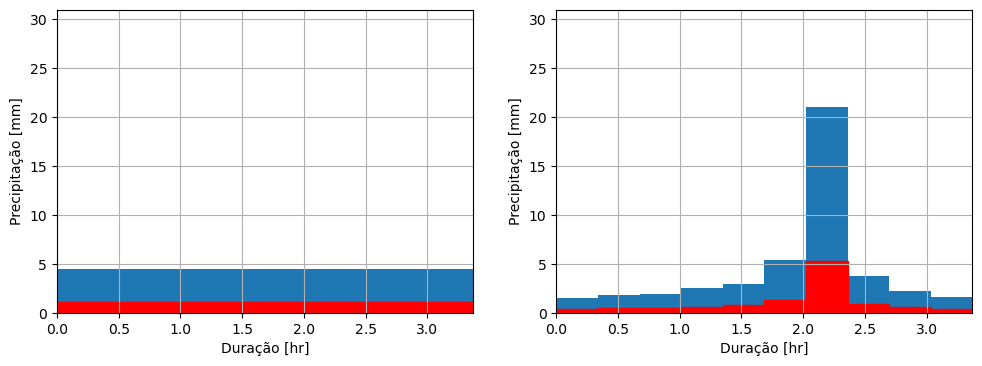

In [20]:
# Cálculo da precipitação efectiva

blocos = np.arange(1, numero_blocos+1)
p_h_uniforme = np.ones(numero_blocos)*intensidade*tc/numero_blocos*60
p_h_alternado = p_h_alternado
hietogramas = pd.DataFrame({'Blocos uniformes [mm]': p_h_uniforme, 'Blocos alternados [mm]': p_h_alternado})
hietogramas.index = pd.MultiIndex.from_arrays([blocos, np.int32(blocos/d/numero_blocos), blocos*tc/numero_blocos], names=('Blocos', 'D', 'Horas'))

p_perdas = hietogramas*perdas
p_efectiva = hietogramas-p_perdas

fig = plt.figure(figsize=(30*cm, 10*cm))
    # Hietograma uniforme
ax0 = fig.add_subplot(gs[:, 0])
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=hietogramas.loc[:, 'Blocos uniformes [mm]'])
ax0.add_patch(patch)
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=p_perdas.loc[:, 'Blocos uniformes [mm]'], color='red')
ax0.add_patch(patch)
ax0.set_xlim(0, tc)
ax0.set_ylim(0, a*(tc/numero_blocos*60)**n+10)

ax0.set_xlabel('Duração [hr]')
ax0.set_ylabel('Precipitação [mm]')
plt.grid()

    # Hietograma alternado
ax0 = fig.add_subplot(gs[:, 1])
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=hietogramas.loc[:, 'Blocos alternados [mm]'])
ax0.add_patch(patch)
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=p_perdas.loc[:, 'Blocos alternados [mm]'], color='red')
ax0.add_patch(patch)
ax0.set_xlim(0, tc)
ax0.set_ylim(0, a*(tc/numero_blocos*60)**n+10)

ax0.set_xlabel('Duração [hr]')
ax0.set_ylabel('Precipitação [mm]')
plt.grid()


In [21]:
print('Hietogramas das precipitações totais')
hietogramas

Hietogramas das precipitações totais


,,,Blocos uniformes [mm],Blocos alternados [mm]
Blocos,D,Horas,,
1,1,0.337100,4.470102,1.519311
2,2,0.674201,4.470102,1.781360
3,3,1.011301,4.470102,1.961656
4,4,1.348402,4.470102,2.514412
5,5,1.685502,4.470102,2.981424
6,6,2.022603,4.470102,5.363108
7,7,2.359703,4.470102,20.995073
8,8,2.696804,4.470102,3.751669
9,9,3.033904,4.470102,2.195606


In [22]:
print('')
print('Hietogramas das precipitações efectivas')
p_efectiva


Hietogramas das precipitações efectivas


,,,Blocos uniformes [mm],Blocos alternados [mm]
Blocos,D,Horas,,
1,1,0.337100,3.352576,1.139483
2,2,0.674201,3.352576,1.336020
3,3,1.011301,3.352576,1.471242
4,4,1.348402,3.352576,1.885809
5,5,1.685502,3.352576,2.236068
6,6,2.022603,3.352576,4.022331
7,7,2.359703,3.352576,15.746305
8,8,2.696804,3.352576,2.813752
9,9,3.033904,3.352576,1.646704


### Executar a convolução (hietograma uniforme)
Já temos toda a informação necessária para calcular a hidrograma de cheia para o período de retorno de 100 anos. Primeiro o hietograma uniforme...

,Bloco 1,Bloco 2,Bloco 3,Bloco 4,Bloco 5,Bloco 6,Bloco 7,Bloco 8,Bloco 9,Bloco 10,Caudal [m3/s]
D,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,8.545336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.545336
2,17.090672,8.545336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.636008
3,25.636008,17.090672,8.545336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.272015
4,34.181344,25.636008,17.090672,8.545336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,85.453359
5,29.298295,34.181344,25.636008,17.090672,8.545336,0.000000,0.000000,0.000000,0.000000,0.000000,114.751654
6,24.415245,29.298295,34.181344,25.636008,17.090672,8.545336,0.000000,0.000000,0.000000,0.000000,139.166899
7,19.532196,24.415245,29.298295,34.181344,25.636008,17.090672,8.545336,0.000000,0.000000,0.000000,158.699095
8,14.649147,19.532196,24.415245,29.298295,34.181344,25.636008,17.090672,8.545336,0.000000,0.000000,173.348243


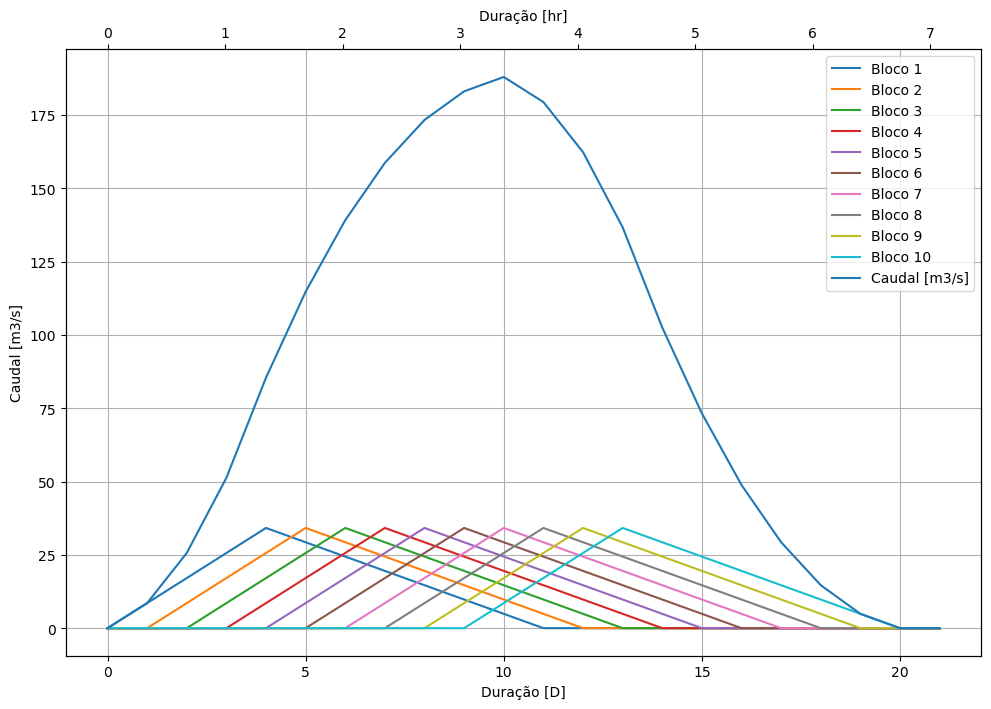

In [23]:
# Convolução para o hietograma uniforme

# Dividir os blocos de precipitação em unidades de "D"
p_tmp = p_efectiva.loc[:, ['Blocos uniformes [mm]']].copy()
p_tmp.index = p_tmp.index.get_level_values(1)
p_tmp = p_tmp.reindex(np.int32(np.arange(1, 1/d+1)))
p_tmp = p_tmp.bfill()

# Calcular a convolução
hud_1mm = hud_1mm.reindex(np.int32(np.arange(0, hud[-1][0] + 1/d + 1)))
hidrogramas_unif = []
for d0 in p_tmp.index:
    hidrogramas_unif.append((p_tmp.iloc[d0-1, 0]*hud_1mm.loc[:, 'u [m3/s]']).shift(d0-1))
hidrogramas_unif = pd.concat(hidrogramas_unif, axis=1)
hidrogramas_unif = hidrogramas_unif.fillna(0)
hidrogramas_unif.columns = ['Bloco %d' % i for i in p_tmp.index]

hidrogramas_unif.loc[:, 'Caudal [m3/s]'] = hidrogramas_unif.sum(axis=1)

# Preparar a figura
fig = plt.figure(figsize=(30*cm, 20*cm))
    # Hietograma
ax0 = fig.add_subplot(gs[:, :])
hidrogramas_unif.plot(ax=ax0)
ax0.set_xlabel('Duração [D]')
ax0.set_ylabel('Caudal [m3/s]')
plt.grid()
ax1 = ax0.twiny()
ax1.set_xlim(ax0.get_xlim()[0]*d_hr, ax0.get_xlim()[1]*d_hr)
_ = ax1.set_xlabel('Duração [hr]')

hidrogramas_unif

### Executar a convolução (hietograma alternado)
O mesmo para o hietograma alternado...

,Bloco 1,Bloco 2,Bloco 3,Bloco 4,Bloco 5,Bloco 6,Bloco 7,Bloco 8,Bloco 9,Bloco 10,Caudal [m3/s]
D,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.904413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.904413
2,5.808827,3.405364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.214191
3,8.713240,6.810727,3.750030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.273997
4,11.617654,10.216091,7.500059,4.806712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.140516
5,9.957989,13.621455,11.250089,9.613425,5.699483,0.000000,0.000000,0.000000,0.000000,0.000000,50.142440
6,8.298324,11.675533,15.000118,14.420137,11.398966,10.252465,0.000000,0.000000,0.000000,0.000000,71.045542
7,6.638659,9.729611,12.857244,19.226849,17.098449,20.504929,40.135543,0.000000,0.000000,0.000000,126.191284
8,4.978994,7.783688,10.714370,16.480156,22.797932,30.757394,80.271085,7.171933,0.000000,0.000000,180.955554


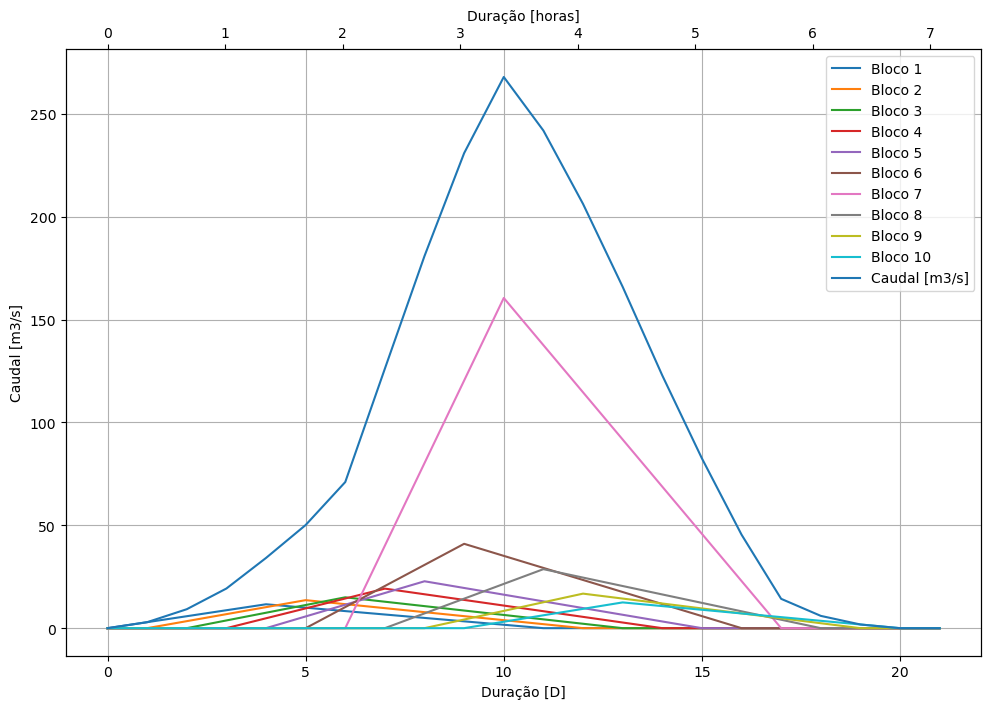

In [24]:
# Convolução para o hietograma alternado

# Dividir os blocos de precipitação em unidades de "D"
p_tmp = p_efectiva.loc[:, ['Blocos alternados [mm]']].copy()
p_tmp.index = p_tmp.index.get_level_values(1)
p_tmp = p_tmp.reindex(np.int32(np.arange(1, 1/d+1)))
p_tmp = p_tmp.bfill()

# Calcular a convolução
hud_1mm = hud_1mm.reindex(np.int32(np.arange(0, hud[-1][0] + 1/d + 1)))
hidrogramas_alt = []
for d0 in p_tmp.index:
    hidrogramas_alt.append((p_tmp.iloc[d0-1, 0]*hud_1mm.loc[:, 'u [m3/s]']).shift(d0-1))
hidrogramas_alt = pd.concat(hidrogramas_alt, axis=1)
hidrogramas_alt = hidrogramas_alt.fillna(0)
hidrogramas_alt.columns = ['Bloco %d' % i for i in p_tmp.index]

hidrogramas_alt.loc[:, 'Caudal [m3/s]'] = hidrogramas_alt.sum(axis=1)

# Preparar a figura
fig = plt.figure(figsize=(30*cm, 20*cm))
ax0 = fig.add_subplot(gs[:, :])
hidrogramas_alt.plot(ax=ax0)
ax0.set_xlabel('Duração [D]')
ax0.set_ylabel('Caudal [m3/s]')
plt.grid()
ax1 = ax0.twiny()
ax1.set_xlim(ax0.get_xlim()[0]*d_hr, ax0.get_xlim()[1]*d_hr)
_ = ax1.set_xlabel('Duração [horas]')

hidrogramas_alt

### Cálculo de volumes e do caudal de ponta segundo a fórmula racional

In [25]:
volume_uniforme_hm3 = (hidrogramas_unif.iloc[1:, [-1]] + hidrogramas_unif.iloc[:-1, [-1]]).sum()*d*tc*3600/1000000/2
volume_alternado_hm3 = (hidrogramas_alt.iloc[1:, [-1]] + hidrogramas_alt.iloc[:-1, [-1]]).sum()*d*tc*3600/1000000/2

print(f'Os volumes de cheia são: {volume_uniforme_hm3} hm3 (hiet. uniforme) e {volume_alternado_hm3} hm3 (hiet. alternado).')

C_ = (1-perdas)
i_ = p_projecto/tc/3600/1000 # m/s
A_ = area * 1000000 # m2

Qp_uniforme = C_*i_*A_

f = 2-np.sqrt(n)
Qp_alternado = Qp_uniforme * f

print('Os caudais de ponta de cheia são:')
pd.DataFrame({'Qp_uniforme [m3/s]': hidrogramas_unif.iloc[:, -1].max(),
              'Qp_racional [m3/s]': Qp_uniforme,
              'intensidade [m/s]': i_,
              'area [m]': A_,
              'Qp_alternado [m3/s]': hidrogramas_alt.iloc[:, -1].max(),
              'Qp_racional_maj. [m3/s]': Qp_alternado,
              'fator de maj. [-]': f}, index=['Valores'],
              )

Os volumes de cheia são: Caudal [m3/s]    2.281464
dtype: float64 hm3 (hiet. uniforme) e Caudal [m3/s]    2.281464
dtype: float64 hm3 (hiet. alternado).
Os caudais de ponta de cheia são:


,Qp_uniforme [m3/s],Qp_racional [m3/s],intensidade [m/s],area [m],Qp_alternado [m3/s],Qp_racional_maj. [m3/s],fator de maj. [-]
Valores,187.99739,187.99739,0.000004,68051078.0,267.985095,268.29344,1.427113


### Finalmente, comparar os dois...

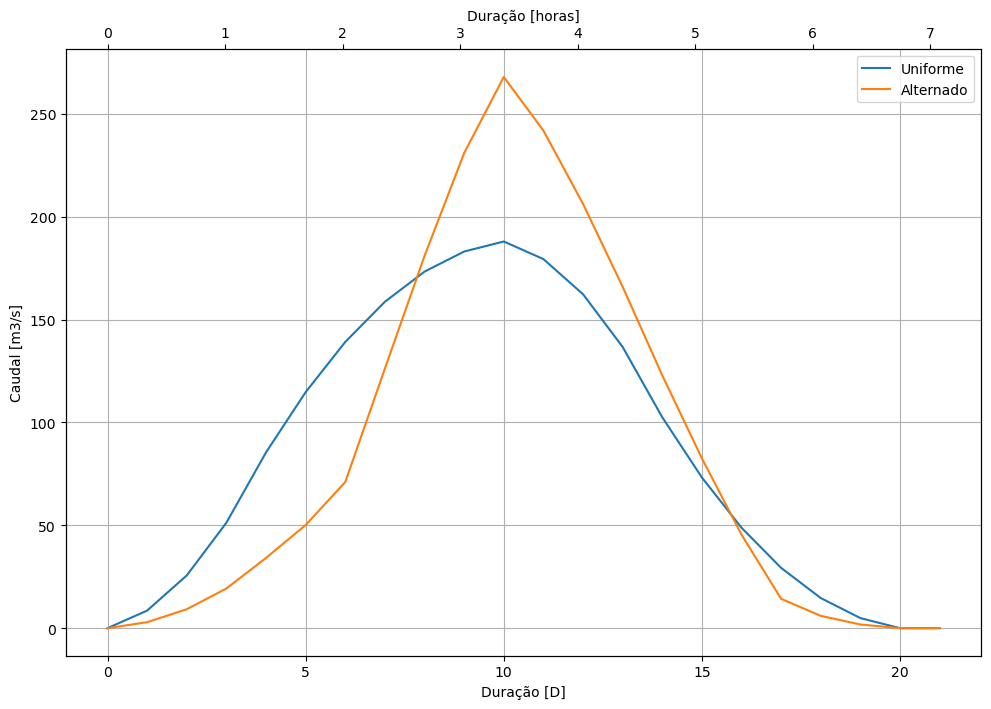

In [26]:
hidrogramas = pd.concat((hidrogramas_unif.loc[:, 'Caudal [m3/s]'], hidrogramas_alt.loc[:, 'Caudal [m3/s]']), axis=1)
hidrogramas.columns = ['Uniforme', 'Alternado']

fig = plt.figure(figsize=(30*cm, 20*cm))
ax0 = fig.add_subplot(gs[:, :])
hidrogramas.plot(ax=ax0)
ax0.set_xlabel('Duração [D]')
ax0.set_ylabel('Caudal [m3/s]')
plt.grid()
ax1 = ax0.twiny()
ax1.set_xlim(ax0.get_xlim()[0]*d_hr, ax0.get_xlim()[1]*d_hr)
_ = ax1.set_xlabel('Duração [horas]')